In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'enso'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

nx = 64
ny = 64
#nt = 200
total_time = 86400*120
nt = 500

picture_frequency = 0
output_frequency = 20
diagnostic_frequency = output_frequency

dx = 200e3
dy = dx

#grav = 9.81
grav = 0.02
rho = np.array([1024.])
nz = rho.size

beta = 2e-11
f0 = -ny*dy/2.*beta

#H0 = (500e3**2*beta)**2 /9.81
H0 = 500.
cph = np.sqrt(grav*H0)
#dt  = 0.1*dx/np.sqrt(grav*H0)
dt = 1800.
dist = dt*nt * cph
nt = int(total_time/dt)
print(f'Running for {nt} time steps.')

kh = 1000.
Ah = kh

do_momentum_advection = False
do_momentum_diffusion = False
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_height_diffusion = False

Running for 5760 time steps.


In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
cn = (H0*grav)**0.5
hn = cn**2/grav
Re = (cn/beta)**0.5
y0 = ny*dy*0.5
A = 0.1
eta0[0,:,:] = 0.1*np.exp( -(Xt-0.3*y0)**2/(2*Re)**2
                          -(Yt-y0)**2/(2*Re)**2 )
eta0[1,:,:] = -H0
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

#uo0 = cph + 0.*Xu
#uo0 = uo0[np.newaxis,:,:]

maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.
maskt0[:,:,0] = 0.
maskt0[:,:,-1] = 0.

#eta_bot0[:,:ny//2,:] = H0
#eta_bot0[:,ny//2:,:] = H0
#H0 = 0.

#ix = np.array([nx//2, nx//2])
#iy = np.array([1*ny//4, 3*ny//4])
ix = np.array([nx//2])
iy = np.array([1*ny//4])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =   5740/  5760, Total run time: 0.56min, done at 2022-08-26 13:00:23.314522, ho.sum = 1.9e+06, ke.sum = 7.0e-07, cflu = 1.1e-06, cflv = 8.5e-07
--- All done! ---
Total run time: 0.56min, done at 2022-08-26 13:00:23.308631
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    ds = xr.open_mfdataset(f'{path_data}/{file_prfx}_????.nc', **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/enso//shallowpy_combined.nc
CPU times: user 8.06 s, sys: 1.78 s, total: 9.84 s
Wall time: 8.69 s


## Plot overview

In [10]:
nps = ds.time.size
nps

288

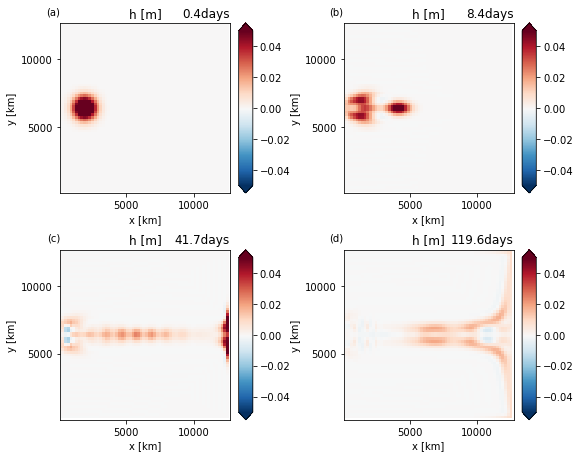

In [11]:
# prepare the animation
iz = 0
steps = [1, 20, 100, nps-1]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=1., fig_size_fac=1.5,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    clim = 5e-2
    hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

## Make an animation

In [12]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

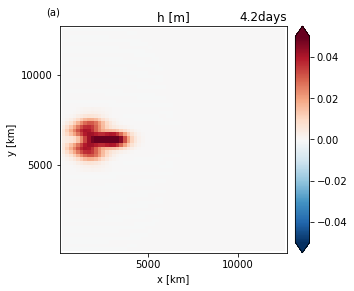

In [13]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=1.00, fig_size_fac=2,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = 5e-2
hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')




In [14]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [15]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/enso///enso.mp4
CPU times: user 12.5 s, sys: 1.47 s, total: 13.9 s
Wall time: 13.8 s


## Showing the animation

In [16]:
%%time
HTML(ani.to_jshtml())

CPU times: user 13.3 s, sys: 1.34 s, total: 14.7 s
Wall time: 14.7 s
